# Fourier Neural Operator 2D + Time

## Navier-Stokes equation

---

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from pprint import pprint

from fourier_2d_time_for_nb import *


In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"

In [5]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0,1,2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0,1,2


In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

In [7]:
torch.manual_seed(0)
np.random.seed(0)


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

if device=='cuda':
    torch.cuda.set_device(2)
    

Using device: cuda


In [9]:
print("How many GPUs are there?")
print(torch.cuda.device_count())

print("Which GPU Is The Current GPU?")
print(torch.cuda.current_device())

print("Get the name of the current GPU")
print(torch.cuda.get_device_name(torch.cuda.current_device()))

How many GPUs are there?
4
Which GPU Is The Current GPU?
0
Get the name of the current GPU
TITAN X (Pascal)


# Hyperparamètres

In [27]:
################################################################
# configs
################################################################

# TRAIN_PATH = 'data/ns_data_V100_N1000_T50_1.mat'
# TEST_PATH = 'data/ns_data_V100_N1000_T50_2.mat'

TRAIN_PATH = 'data/ns_V1e-3_N5000_T50.mat'
TEST_PATH = 'data/ns_V1e-3_N5000_T50.mat'


ntrain = 1000
ntest = 200

modes = 12
width = 20

batch_size = 20
batch_size2 = batch_size

# epochs = 500
epochs = 150

learning_rate = 0.001
scheduler_step = 100
scheduler_gamma = 0.5

print(epochs, learning_rate, scheduler_step, scheduler_gamma)

path = 'ns_fourier_2d_rnn_V10000_T20_N'+str(ntrain)+'_ep' + str(epochs) + '_m' + str(modes) + '_w' + str(width)
path_model = 'model/'+path
path_train_err = 'results/'+path+'train.txt'
path_test_err = 'results/'+path+'test.txt'
path_image = 'image/'+path

runtime = np.zeros(2, )

sub = 1
S = 64
T_in = 10
T = 10
step = 1

150 0.001 100 0.5


## Loading Data

In [16]:
################################################################
# load data
################################################################

t1 = default_timer()

reader = MatReader(TRAIN_PATH)
train_a = reader.read_field('u')[:ntrain,::sub,::sub,:T_in]
train_u = reader.read_field('u')[:ntrain,::sub,::sub,T_in:T+T_in]

reader = MatReader(TEST_PATH)
test_a = reader.read_field('u')[-ntest:,::sub,::sub,:T_in]
test_u = reader.read_field('u')[-ntest:,::sub,::sub,T_in:T+T_in]

print(train_u.shape)
print(test_u.shape)
assert (S == train_u.shape[-2])
assert (T == train_u.shape[-1])

train_a = train_a.reshape(ntrain,S,S,T_in)
test_a = test_a.reshape(ntest,S,S,T_in)


train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=batch_size, shuffle=False)

t2 = default_timer()

print('preprocessing finished, time used:', t2-t1, "seconds")


torch.Size([1000, 64, 64, 10])
torch.Size([200, 64, 64, 10])
preprocessing finished, time used: 232.06501277908683


In [17]:
print(train_u.shape)

torch.Size([1000, 64, 64, 10])


In [18]:
print(test_u.shape)

torch.Size([200, 64, 64, 10])


## Model

In [23]:
# model
model = FNO2d(modes, modes, width).to(device)
print(count_params(model))

465717


## Training

In [24]:
################################################################
# training and evaluation
################################################################
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

In [28]:
for xx, yy in train_loader:
    print(xx.shape)
    print(yy.shape)
    break

torch.Size([20, 64, 64, 10])
torch.Size([20, 64, 64, 10])


In [29]:
yy[..., 5:6].shape

torch.Size([20, 64, 64, 1])

In [32]:
list_train_l2_step = []
list_train_l2_full = []
list_test_l2_step = []
list_test_l2_full = []


myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2_step = 0
    train_l2_full = 0
    for xx, yy in train_loader:
        loss = 0
        xx = xx.to(device)
        yy = yy.to(device)

        for t in range(0, T, step):
            y = yy[..., t:t + step]
            
#             print("xx", xx.shape)
            im = model(xx)
#             print("im", im.shape)
            
            
            loss += myloss(im.reshape(batch_size, -1), y.reshape(batch_size, -1))

            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), -1)
#             print("pred: ", pred.shape)

            xx = torch.cat((xx[..., step:], im), dim=-1)

        train_l2_step += loss.item()
        l2_full = myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1))
        train_l2_full += l2_full.item()
        
        
        list_train_l2_step.append(train_l2_step)
        list_train_l2_full.append(train_l2_full)
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    test_l2_step = 0
    test_l2_full = 0
    with torch.no_grad():
        for xx, yy in test_loader:
            loss = 0
            xx = xx.to(device)
            yy = yy.to(device)

            for t in range(0, T, step):
                y = yy[..., t:t + step]
                im = model(xx)
                loss += myloss(im.reshape(batch_size, -1), y.reshape(batch_size, -1))

                if t == 0:
                    pred = im
                else:
                    pred = torch.cat((pred, im), -1)

                xx = torch.cat((xx[..., step:], im), dim=-1)

            test_l2_step += loss.item()
            test_l2_full += myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1)).item()
            
            list_test_l2_step.append(test_l2_step)
            list_test_l2_full.append(test_l2_full)

    t2 = default_timer()
    scheduler.step()
    
    # PRINT
    print(ep, t2 - t1, train_l2_step / ntrain / (T / step), train_l2_full / ntrain, test_l2_step / ntest / (T / step),
          test_l2_full / ntest)

0 8.096167165786028 0.010878552520275116 0.011104288905858994 0.010285595059394836 0.010621284618973732
1 7.555255263112485 0.008520608365535736 0.008691877022385597 0.009419095158576965 0.00958566576242447
2 7.5120590990409255 0.009489574897289275 0.009770955353975297 0.011847819328308105 0.012324710190296174
3 7.900757325813174 0.011377504861354828 0.011833433985710145 0.01223247241973877 0.012512789592146873
4 7.596716989763081 0.009802041518688203 0.010059589117765427 0.009261160910129547 0.009441049844026566
5 7.554622030816972 0.007999984669685364 0.00815754197537899 0.008494712233543396 0.008568430468440056
6 7.50306524336338 0.007998646450042725 0.008124677792191505 0.008136328637599945 0.008288164809346198
7 7.5163263054564595 0.007545607578754425 0.007661946162581444 0.009504297137260437 0.009696564599871636
8 7.490103698335588 0.008078445851802826 0.008224765852093696 0.007557667315006256 0.007669968456029892
9 7.437162798829377 0.007381876921653747 0.007502685949206353 0.00

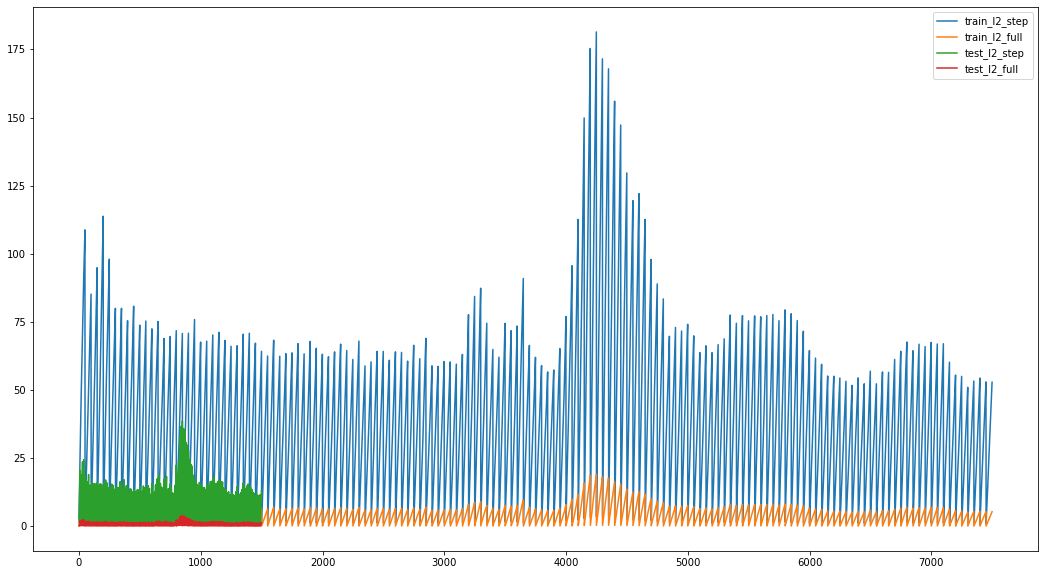

In [33]:
fig = plt.figure(figsize=(18, 10))

to_plot_list = list(zip(
    ('train_l2_step', 'train_l2_full', 'test_l2_step', 'test_l2_full'), 
    (list_train_l2_step, list_train_l2_full, list_test_l2_step, list_test_l2_full)) )
for couple in to_plot_list:
    couple_label, couple_data = couple
    plt.plot(couple_data, label=couple_label)
plt.legend()
plt.show()

In [34]:
for liste in (list_train_l2_step, list_train_l2_full, list_test_l2_step, list_test_l2_full):
    print(len(liste))

7500
7500
1500
1500
